In [18]:
import requests
from urllib.parse import quote
import pandas as pd
import numpy as np
import folium

In [19]:
with open('kakao api.txt', mode = 'r') as key_file :
    kakao_key = key_file.read()
local_url = 'https://dapi.kakao.com/v2/local/search/address.json'

In [40]:
park = pd.read_csv('서울시 주요 공원현황.csv', encoding = 'euckr')
park['면적'] = park['면적'].fillna(0)

In [41]:
def sum_area(string) :
    if string == 0 :
        return 0

    sum_list = string.strip().split('㎡')
    area = 0
    for i in sum_list :
        if i == '' :
            continue
        area += float(i)

    return area

In [ ]:
park['area'] = park['면적'].map(sum_area).astype(int)

In [45]:
lng = []
lat = []
addr = []

for i in park['공원주소'].index :
    try :
        url = f'{local_url}?query={quote(park["공원주소"][i])}'
        result = requests.get(url, headers = {"Authorization": f'KakaoAK {kakao_key}'}).json()
        for key, value in result['documents'][0].items() :
            if key == 'x' :
                lng.append(value)
            if key == 'y' : 
                lat.append(value)
            if key == 'address_name' :
                addr.append(value)
    except :
        print(i + 2)

In [46]:
data = {
    'name' : park['공원명'],
    'address' : addr,
    'latitude' : lat,
    'longitude' : lng,
    'area' : park['area']
}
seoul_park = pd.DataFrame(data)
seoul_park.to_csv('seoul_park.csv', index = False, sep = ',')

In [47]:
seoul_park = pd.read_csv('seoul_park.csv')
seoul_park

,name,address,latitude,longitude,area
0,남산도시자연공원,서울 중구 삼일대로 231,37.555633,126.992218,5793774
1,길동생태공원,서울 강동구 천호대로 1291,37.539066,127.153329,80683
2,서울대공원,경기 과천시 대공원광장로 102,37.436431,127.014098,9132690
3,서울숲,서울 성동구 뚝섬로 273,37.543070,127.041799,480994
4,월드컵공원,서울 마포구 하늘공원로 84,37.572327,126.881889,2284085
...,...,...,...,...,...
127,용마도시자연공원(사가정공원),서울 중랑구 면목동 산 50-26,37.579725,127.095934,109635
128,문화비축기지,서울 마포구 증산로 87,37.570347,126.895031,140022
129,경춘선숲길,서울 노원구 공릉동 272-2,37.619934,127.080103,211392
130,율현공원,서울 강남구 밤고개로24길,37.472197,127.106178,157535


<AxesSubplot:ylabel='Frequency'>

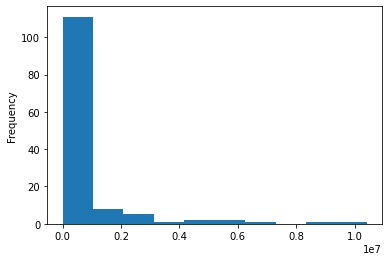

In [52]:
seoul_park.area.plot(kind = 'hist')

In [56]:
area_criteria = [-1, 100000, 1000000, 12000000]
labels = ['small', 'middle', 'big']
size = [3, 7, 15]

seoul_park['scale'] = pd.cut(seoul_park.area, area_criteria, labels = labels)
seoul_park['size'] = pd.cut(seoul_park.area, area_criteria, labels = size)
seoul_park

,name,address,latitude,longitude,area,scale,size
0,남산도시자연공원,서울 중구 삼일대로 231,37.555633,126.992218,5793774,big,15
1,길동생태공원,서울 강동구 천호대로 1291,37.539066,127.153329,80683,small,3
2,서울대공원,경기 과천시 대공원광장로 102,37.436431,127.014098,9132690,big,15
3,서울숲,서울 성동구 뚝섬로 273,37.543070,127.041799,480994,middle,7
4,월드컵공원,서울 마포구 하늘공원로 84,37.572327,126.881889,2284085,big,15
...,...,...,...,...,...,...,...
127,용마도시자연공원(사가정공원),서울 중랑구 면목동 산 50-26,37.579725,127.095934,109635,middle,7
128,문화비축기지,서울 마포구 증산로 87,37.570347,126.895031,140022,middle,7
129,경춘선숲길,서울 노원구 공릉동 272-2,37.619934,127.080103,211392,middle,7
130,율현공원,서울 강남구 밤고개로24길,37.472197,127.106178,157535,middle,7


In [60]:
seoul_park_map = folium.Map(location = [seoul_park['latitude'].mean(), seoul_park['longitude'].mean()], zoom_start = 11)
for i in seoul_park.index :
    folium.CircleMarker(location = [seoul_park['latitude'][i], seoul_park['longitude'][i]], radius = int(seoul_park['size'][i]), tooltip = f'{seoul_park.name[i]}({seoul_park.area[i]:,d})㎡)', color = '#234972', fill_color = '#234972').add_to(seoul_park_map)
seoul_park_map